# Blood Glucose Control - EDA

**Name:** [*Junwon Park*]



# Data Cleaning

### Import Data and libraries

There are multiple data sets each corresponding to a person with diabetes. Please load the files into a single data set while retaining the ability to distinguish between the PWD. 

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import numpy as np

df1 = pd.read_csv('../data/gluroo_500030.csv')
df2 = pd.read_csv('../data/gluroo_679372.csv')


### Function to edit the date column

In [69]:
# Function to format the date by removing the time zone and ensuring consistency
def format_date(date):
    if isinstance(date, str):  # Ensure it's a string before parsing
        try:
            # Try parsing with microseconds and timezone
            datetime_obj = datetime.strptime(date, '%Y-%m-%d %H:%M:%S.%f%z')
        except ValueError:
            try:
                # If it fails, try parsing without microseconds
                datetime_obj = datetime.strptime(date, '%Y-%m-%d %H:%M:%S%z')
            except ValueError:
                # Handle cases with no timezone info or microseconds
                try:
                    datetime_obj = datetime.strptime(date, '%Y-%m-%d %H:%M:%S.%f')
                except ValueError:
                    datetime_obj = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
        
        # Return the formatted datetime without timezone, with milliseconds precision
        return datetime_obj.strftime('%y/%m/%d %H:%M:%S.%f')[:-3]
    return date  # If it's not a string, return the original value

Checking if date information is lost if we use the format_date function.

In [70]:
#df1['date'].nunique()# looks like date is not unique, no specified id column.

In [71]:
#df1['date'].apply(format_date).nunique()

looks like no informations is lost

creating a function to create separate columns for date attributes (to make it easier using groupby)

In [72]:
# Function to split the date into components
def separate_date(df):
    # First, apply the format_date function to the 'date' column to clean it up
    df['date'] = df['date'].apply(format_date)
    
    # Now convert the cleaned 'date' column into datetime format
    df['date'] = pd.to_datetime(df['date'], format='%y/%m/%d %H:%M:%S.%f')
    
    # Extract year, month, day, etc.
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['date'].dt.hour
    df['minute'] = df['date'].dt.minute
    df['second'] = df['date'].dt.second
    df['seconds_with_micro'] = df['date'].dt.second + df['date'].dt.microsecond / 1_000_000
    
    return df

# Applying the function to the dataframe
df1 = separate_date(df1)


In [73]:
df1 = separate_date(df1.apply(format_date))
df2 = separate_date(df2.apply(format_date))

# Data Description

In [74]:
#tmp = df1.groupby(by=['date']).size().reset_index(name='count')
#tmp[tmp['count']>1] ## looks like there are overlapping dates 
# found multiple counts for same date and time for same bgl level but different food_g?

In [75]:
# Example case when with rows with same time but differnt info, these columns had different info
#df1[df1['date'] == '2024-05-13 04:46:16.639'][['text','food_g']]

In [76]:
#df1.info()

In [77]:
#df2.info()

# Meal Identification

`Objective`: Identify meal events from continuous blood glucose time series data.

`Approach`:

- Time Series Analysis: Detect spikes / rapid changes in blood glucose levels that could indicate meal times.
- Pattern Recognition: Look for patterns typically associated with meals, such as rapid rises followed by gradual decreases.
- Feature Engineering: Create features that could help identify meals, such as the rate of change, peak glucose levels after a spike, and the time interval between changes.
- Visualization: Plot glucose levels around suspected meal times to validate whether these periods coincide with expected meal-induced changes.

## Meal Identification - Interesting Columns

**Time and Context**: The `date`, `year`, `month`, `day`, and `seconds_with_micro` columns help establish the exact timing of meals, insulin doses, and glucose trends, which are crucial for linking these events to meals.

**Glucose Response**: The `bgl`, `bgl_date_millis`, and `trend` columns provide direct measurements of how glucose levels respond around meal times.

**Insulin and Food Intake**: `dose_units`, `affects_iob`, and `food_g` give insights into the interaction between insulin dosing and carbohydrate intake, both of which are critical for identifying meal impacts.

**Meal and Insulin Events**: The `msg_type` column specifically flags meal announcements (`ANNOUNCE_MEAL`) and insulin doses (`DOSE_INSULIN`), which are direct indicators of meal events.

**Detailed Food Analysis**: `food_glycemic_index` and `food_g` provide a deeper understanding of how the type and amount of food consumed affect glucose levels.

**Manual Logs and Notes**: The `text` column can capture additional details that may not be recorded in structured data, such as corrections, user observations, or adjustments.


These are the simplified version of necessary columns but for this I would do more in depth feature selection. For now I have selected columns above.

In [78]:
# List of columns to filter in df1
columns_to_filter = [
    'date', 'year', 'month', 'day', 'hour', 'minute', 'second', 'seconds_with_micro', 'bgl', 
    'bgl_date_millis', 'text', 'dose_units', 'sender_id', 'msg_type', 
    'affects_fob', 'affects_iob', 'trend', 'dose_automatic', 
    'food_glycemic_index', 'food_g'
]

# Filtering the DataFrame to only include the specified columns
df1_MI = df1[columns_to_filter]
df2_MI = df2[columns_to_filter]

In [79]:
# Find the max of the minimum dates and min of the maximum dates
start_date = max(df1_MI['date'].min(), df2_MI['date'].min())
end_date = min(df1_MI['date'].max(), df2_MI['date'].max())

# Filter both DataFrames by the overlapping date range
df1_filtered = df1_MI[(df1_MI['date'] >= start_date) & (df1_MI['date'] <= end_date)]
df2_filtered = df2_MI[(df2_MI['date'] >= start_date) & (df2_MI['date'] <= end_date)]

**Objective:** My goal is to determine whether two users' data are significantly different. If I find that their data patterns diverge meaningfully, I plan to develop a generalized model initially and then train user-specific models for each individual.

To start, I will focus on a single user and analyze their data. If I find statistically significant differences between users later on, I will create personalized models that better capture the unique characteristics of each user's data.

## Meal Identification - Quick Statistical Test

**Requirements**

- Assume that we have 2 randomly picked users from a population of **N** users.

- We have these two users as independent from each other

- `bgl` is continuous variable

 $H_0:$ the distribution of `bgl` from two users are the SAME $\quad$ **VS** $\quad$ $H_1:$ the distribution of `bgl` from two users are the DIFFERENT

We are testing if two users have differnt distributions or not, if we have enough evidence for nul hypothesis then the distribution is mostlikely the same. Meaning we can use same model for independent users.

In [85]:
from scipy.stats import ks_2samp

# Perform the K-S test
stat_ks, p_ks = ks_2samp(df1_filtered['bgl'].dropna(), df2_filtered['bgl'].dropna())

print(f"Kolmogorov-Smirnov test statistic: {stat_ks}")
print(f"P-value: {p_ks}")


Kolmogorov-Smirnov test statistic: 0.3271653252520871
P-value: 0.0


Since we have a p-value < 0.05 we have strong evidence against $H_0$. This means the two users do not follow same distribution meaning that each user requires unique model training.

## Meal Identification - Plots

In [86]:
# the function below will help with plotting, it will plot specified y column and you can also specify how may samples (unique days) you want to visualize
def plot_trends_by_time(df, y_col, n_samples=3, specific_date=None):
    # If a specific date is provided, use it; otherwise, sample random dates
    if specific_date:
        # Convert specific_date from string to datetime for comparison
        specific_date = pd.to_datetime(specific_date)
        # Filter rows for the specific date
        df_random_samples = df[
            (df['year'] == specific_date.year) &
            (df['month'] == specific_date.month) &
            (df['day'] == specific_date.day)
        ]
    else:
        # Get unique combinations of year, month, and day
        unique_dates = df[['year', 'month', 'day']].drop_duplicates()

        # Randomly sample unique date combinations
        random_dates = unique_dates.sample(n=n_samples)

        # Select all rows that belong to the sampled dates
        df_random_samples = df.merge(random_dates, on=['year', 'month', 'day'])

    # Create a new column for the formatted time as 'hour:min'
    df_random_samples['time_formatted'] = df_random_samples.apply(
        lambda row: f"{int(row['hour']):02d}:{int(row['minute']):02d}", axis=1
    )

    # Create a new column combining year, month, and day for the hue/legend
    df_random_samples['date_label'] = df_random_samples.apply(
        lambda row: f"{int(row['year'])}-{int(row['month']):02d}-{int(row['day']):02d}", axis=1
    )

    # Sort the data by time to ensure proper plotting
    df_random_samples = df_random_samples.sort_values(by=['hour', 'minute'])

    # Set up the figure
    plt.figure(figsize=(12, 6))

    # Plot the data with date_label as hue to distinguish lines by date
    sns.lineplot(data=df_random_samples, x='time_formatted', y=y_col, hue='date_label', marker='o')

    # Reduce the number of ticks shown on the x-axis
    x_ticks = np.arange(0, len(df_random_samples['time_formatted']), step=30)  # Adjust 'step' to control density
    plt.xticks(ticks=x_ticks, labels=df_random_samples['time_formatted'].iloc[x_ticks], rotation=45)

    # Title and labels
    plt.title(f'Trends for {"Specific Date: " + specific_date.strftime("%Y-%m-%d") if specific_date else "Randomly Sampled Dates"} (Overlay by Hour and Minute): {y_col}')
    plt.xlabel('Time (HH:MM)')
    plt.ylabel(y_col)
    plt.legend(title='Date')
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_trends_by_time(df, 'bgl', specific_date='2024-05-15')
# plot_trends_by_time(df, 'bgl', n_samples=3)


Picked this random date for analysis

In [88]:
date = '2024-07-31'

C:\Users\paulp\AppData\Local\Temp\ipykernel_7940\3714981753.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_random_samples['time_formatted'] = df_random_samples.apply(
C:\Users\paulp\AppData\Local\Temp\ipykernel_7940\3714981753.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_random_samples['date_label'] = df_random_samples.apply(


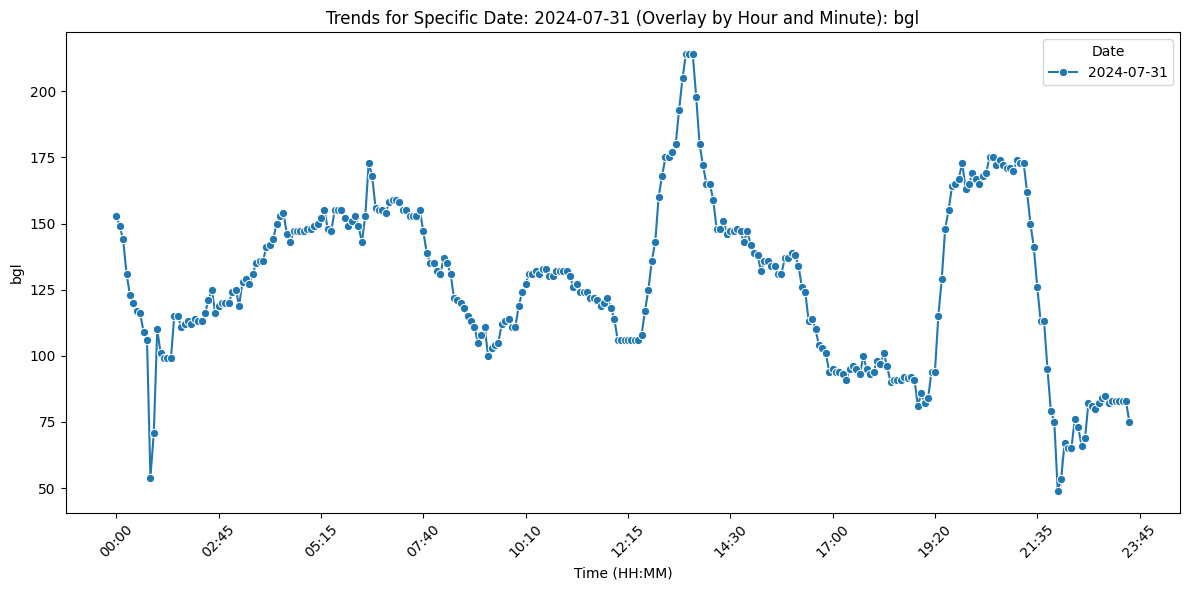

In [89]:
# to plot specific date
plot_trends_by_time(df1_MI,'bgl', specific_date=date)

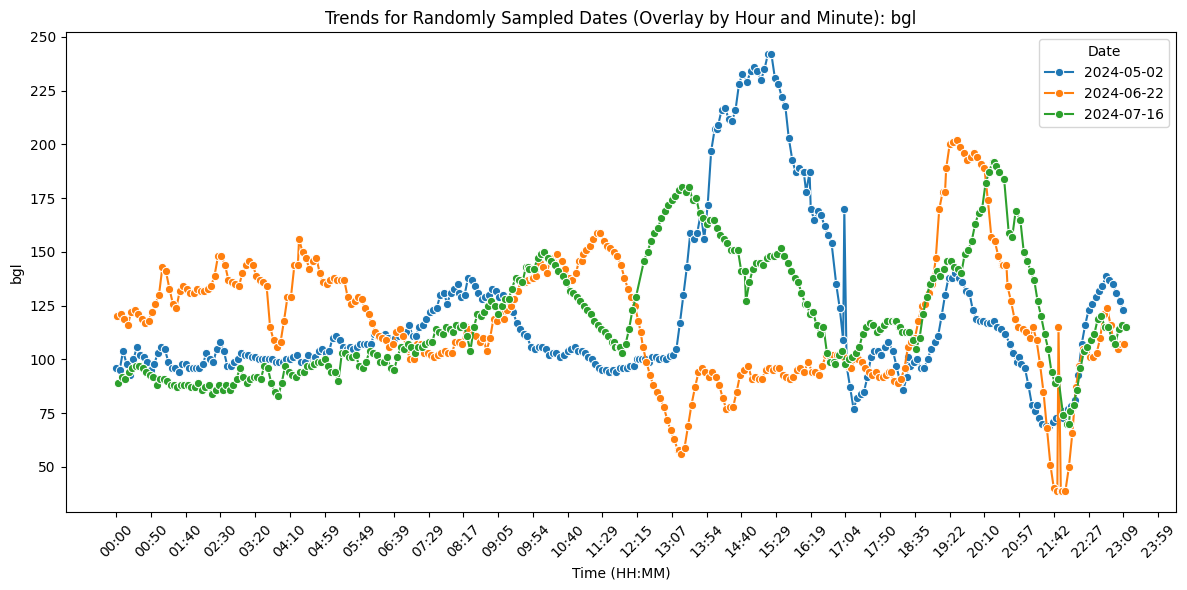

In [90]:
# Example usage of daily plot for bgl level, this will plot 3 random samples in the data
plot_trends_by_time(df1_MI, 'bgl', n_samples = 3)  # 'bgl' is the column for the y-axis.

The graph above plots 3 random days from the user and plots the `bgl` level of the user at that time. 

The purpose of this graph is to see if there is a common trend in `bgl` spikes throughout different times of day. Or to check if there is one.

Overall, the graph does seem to be showing spikes around certain meal times but it differs for each day. Thus no specific seasonality for meal times. Need to find another better method instead of account for meal times. Next option is to plot change in bgl levels per seconds or unit time (potentially could do changes over rolling averages but for now I wanted to see changes in seconds). This will help us see the changes in bgl levels and do a more indepth analysis for specific changes over time.

1.) Lets calculate BGL Rate of Change

In [91]:
def bgl_rate_of_change(df, col_name = 'bgl'):
    # Sort the dataframe by date and time columns
    df = df.sort_values(by=['year', 'month', 'day', 'hour', 'minute', 'second', 'seconds_with_micro'])
    # Calculate the difference in BGL between consecutive measurements
    df['bgl_diff'] = df[col_name].diff()
    # Convert all times into a single measure (seconds since the start of the dataframe)
    df['total_seconds'] = (
        df['second'] +
        df['minute'] * 60 +
        df['hour'] * 3600 +
        df['day'] * 86400 +  # Assuming 'day' column counts the days in the measurement period
        df['month'] * 2628000 +  # Rough average of seconds in a month, not precise
        (df['year'] - df['year'].min()) * 31536000  # Seconds in a year, ignoring leap years
    )
    # Calculate time difference in seconds between consecutive measurements
    df['time_diff'] = df['total_seconds'].diff()
    # Handling division by zero by replacing zero with a very small number (epsilon)
    df['time_diff'] = df['time_diff'].replace(0, 1e-9)
    # Calculate rate of change of BGL
    df['bgl_rate_of_change'] = df['bgl_diff'] / df['time_diff']
    return df


It turns out doing a rolling average detects better peak. I have decided to use an average interval for around 5 minutes which turned out to be `window = 2`. After this, I am planning to calulate the difference in bgl rates for better detection of spikes for meals

In [98]:
# Calcualting average time for specified interval window of 2 datapoints. 
# Create a temporary DataFrame
tmp = pd.DataFrame()
# Calculate the time differences for the specified window size (2 data points, hence shift by 1)
tmp['time_diff'] = (df1_MI['date'] - df1_MI['date'].shift(1)).dt.total_seconds()
# Drop NaN values that appear due to the shift operation
tmp.dropna(inplace=True)
# Calculate the mean of these time differences
average_time_interval = tmp['time_diff'].mean()
average_time_interval/60 # time in minutes

4.776292196663783

Currently doing an average of arond 5 min interval

In [96]:
# Using a rolling window to smooth out BGL and identify meal peaks
df1_MI['bgl_smooth'] = df1_MI['bgl'].rolling(window=2).mean()  # Adjust window size if necessary
# window size 5 means we took the average of 5 consecutive data points to smooth out the points.

C:\Users\paulp\AppData\Local\Temp\ipykernel_7940\3714981753.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_random_samples['time_formatted'] = df_random_samples.apply(
C:\Users\paulp\AppData\Local\Temp\ipykernel_7940\3714981753.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_random_samples['date_label'] = df_random_samples.apply(


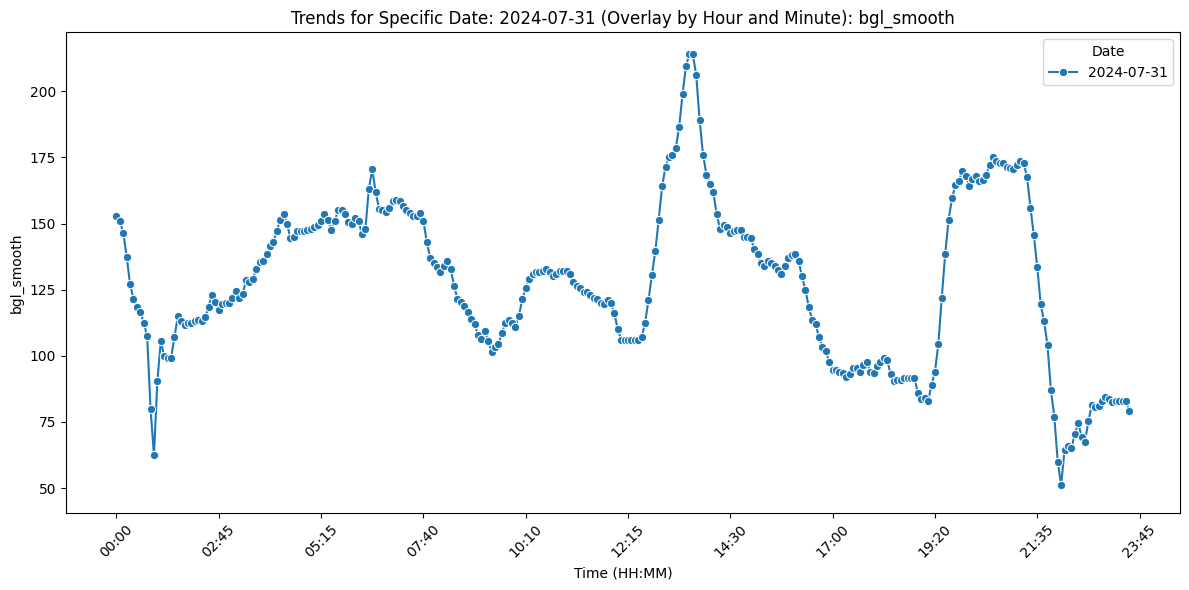

In [97]:
plot_trends_by_time(df1_MI, 'bgl_smooth', specific_date=date)  # 'bgl' is the column for the y-axis.

In [99]:
# doing another rate of change after smoothed bgl
df1_MI = bgl_rate_of_change(df1_MI, col_name='bgl_smooth') ## bgl_rate_of_change will now show the change in smoothed bgl

C:\Users\paulp\AppData\Local\Temp\ipykernel_7940\3714981753.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_random_samples['time_formatted'] = df_random_samples.apply(
C:\Users\paulp\AppData\Local\Temp\ipykernel_7940\3714981753.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_random_samples['date_label'] = df_random_samples.apply(


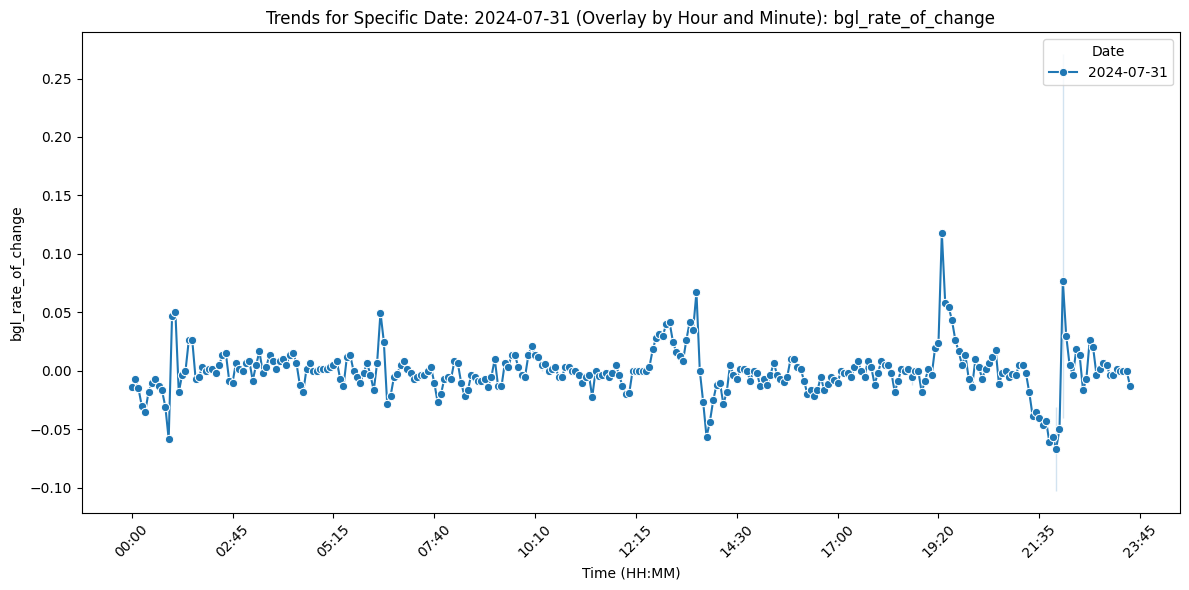

In [100]:
plot_trends_by_time(df1_MI, 'bgl_rate_of_change', specific_date=date)  # 'bgl' is the column for the y-axis.

Plot above shows the rate of change after the smoothed bgl (each point is an average of around 5 min). The change in spikes are significantly lower but we are now able to detect more spikes (increase/decrease) in bgl levels after doing a rolling average.

We can identify spikes from this plot to identify meal changes.

## Meal Identification - Sample Model

we can create a potential time series model where given historical data we calculate the average range in normal bgl level. For simplicity lets conduct it for just considering the bgl_rate_of_change for now. This is just to get a brief idea of how the model should work.

5.) Cluster Analysis for Meal Detection:
If you want a more advanced approach, you can use clustering techniques like KMeans to group BGL patterns that correspond to meals.

In [28]:
# Select features that may influence meal patterns
features = df1_MI[['bgl', 'bgl_diff', 'hour', 'food_g', 'dose_units']].fillna(0)

# Fit a KMeans model to cluster meal times
kmeans = KMeans(n_clusters=3, random_state=42)
df1_MI['meal_cluster'] = kmeans.fit_predict(features)

# Analyze clusters to understand meal times

In [29]:
df1_MI['meal_cluster']

0        1
1        1
2        1
3        1
4        1
        ..
27732    0
27733    0
27734    0
27735    0
27736    0
Name: meal_cluster, Length: 27737, dtype: int32

need to check if each user has similar bgl level. I am expecting different so each user should be modeled with unique models. The main model would go though each user's data and use feature selections to find important features that helps identify spikes in bgl level which can be potential meal times.

For now I need to check the average glucose level for the two given user and make sure they have different average bgl to apply the theory above.


My main plots can be the feature selection plot along with the average bgl level for same time period for the two users.

# Mean Scoring

`Objective:` Assess the average glucose levels over time to identify periods of good or poor control.

`Approach:`

- Calculate Mean Glucose Levels: Compute the mean glucose levels over specific time windows (e.g., hourly, daily) to get a sense of average control.
- Categorize Control Quality: Define ranges for good, moderate, and poor control (e.g., using thresholds like 70-180 mg/dL).
- Temporal Analysis: Analyze how mean glucose scores change over time to identify trends in control quality.
- Comparisons: Compare mean glucose levels across different contexts (e.g., weekdays vs. weekends, before vs. after interventions).

In [ ]:
# Visualize mean glucose scores with thresholds marked to highlight periods of good or poor control.
# Use bar plots or line charts to track changes in mean glucose levels over time.

# Prandial Interventions and Counterfactuals

`Objective:` Explore how interventions around meals (e.g., insulin doses) impact glucose levels and simulate potential outcomes of alternative strategies.

`Approach:`

- Identify Prandial Interventions: Locate points in the data where insulin or other interventions were administered around meal times.
- Analyze Intervention Effectiveness: Assess the impact of these interventions by comparing glucose levels before and after the intervention.
- Counterfactual Analysis: Hypothesize what might have happened if a different intervention had been used (e.g., delayed insulin administration).
- Visualization: Use plots to show glucose trajectories with and without interventions, and overlay counterfactual scenarios.

In [ ]:
# Create side-by-side plots showing actual vs. hypothetical glucose responses to different prandial interventions.
# Highlight instances where the intervention timing or dosage could be optimized.

# Blood Glucose Controller

`Objective:` Understand how well blood glucose is being maintained within target ranges and identify areas for potential improvement.

`Approach:`

- Control Analysis: Identify periods where glucose levels are within, above, or below the target range (70-180 mg/dL).
- Glucose Variability Assessment: Evaluate metrics such as standard deviation, coefficient of variation, or time-in-range to assess overall control stability.
- Predictive Modeling: Explore simple models that can predict future glucose levels based on current and past data.
- Visualization: Use control charts or time-in-range plots to show overall control performance.

In [ ]:
# Generate time-in-range plots that show how often glucose levels are within the target range.
# Use scatter plots to show variability and trends that might indicate a need for controller adjustments.

### Two Data Visualizations

Create at least two visualizations that are of interest to you. They can be things that would be useful information for a PWD to know, or they could be useful for informing future modeling work. If you aren't sure what to visualize try recreating common diabetes data visualizations that you can find on the internet. 

### Ask a question(s) about the data and/or diabetes!
When creating the visualizations you probably had some questions about managing T1D. Ask some questions that might interest you and our diabetes experts will do their best to answer them for you! *Consider this an AMAA about diabetes.* 

1. Why do multiple rows share the same date but have different entries in the food_g and text columns? Could this be because multiple foods were logged on the same day, or is it an unintended duplication? What would be the best way to address this: should we consolidate these rows, or are they meant to represent separate entries?


2. [Question 2]

### Final Task

Thanks for showing interest in our project! We plan to incorporate the best/most interesting visualizations into a substack post in the future. 

Please remember to create a pull request with your updated template, don't forget to rename the file to something that we can identify you with, e.g: `eda_[your_name].ipynb`